# Homework 1 
## Cirstyn Michel

# Comments

1. Very nice work. You covered all of the questions, and your results look good.
1. I had some minor comments that you'll find as markdown cells with **comment**.

### Notebook Set Up and Helper Functions

In [1]:
import controlSBML as ctl

import control
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te
from IPython.display import Image
from IPython.core.display import HTML
ctl.__version__

'1.0.7'

In [2]:
def plotSys(sys, times=None, initial_values=None, forced_input=None, title="", ax=None, output_labels=None, is_plot=True):
    """
    Plots the system.
    
    Parameters
    ----------
    sys: NonlinearIOSystem
    times: list-float (times for simulation)
    initial_values: list-float
    forced_input: list-float
    ax: matplotlib.Axes
    output_labels: list-str (names for output labels)
    
    Returns
    -------
    np.ndarray, np.ndarray, ax (times, predicted values, plot axis)
    """
    if times is None:
        times = np.linspace(0, 5, 100)
    if forced_input is None:
        ncol = len(times)
        nrow = len(sys.input_labels)
        forced_input = np.array([np.repeat(0, nrow) for _ in range(ncol)])
        forced_input = np.reshape(forced_input, (nrow, ncol))
    if initial_values is None:
        initial_values = ctl.makeStateVector(sys)
    if ax is None:
        _, ax = plt.subplots(1)
    if output_labels is None:
        output_labels = list(sys.output_labels)
    # Simulate the system
    t, y = control.input_output_response(sys, times, forced_input, initial_values)
    # Plot the response
    num_output = len(output_labels)
    if num_output == 1:
        if y.ndim == 1:
            plt.plot(t, y)
            plt.plot(t, [forced_input]*len(t))
        else:
            plt.plot(t, y[0])
    else:
        for idx in range(num_output):
            ax.plot(t, y[idx])
    ax.legend(["Gp","setpoint"])
    if not is_plot:
        plt.close()
    return t, y, ax
    
# Tests
#times = T = np.linspace(0, 70, 500)
#times, predictions, _ = plotSys(TEST_SYS, times, is_plot=False)
#assert(len(times) == len(predictions[0]))
print("OK!")

OK!


# Question 1

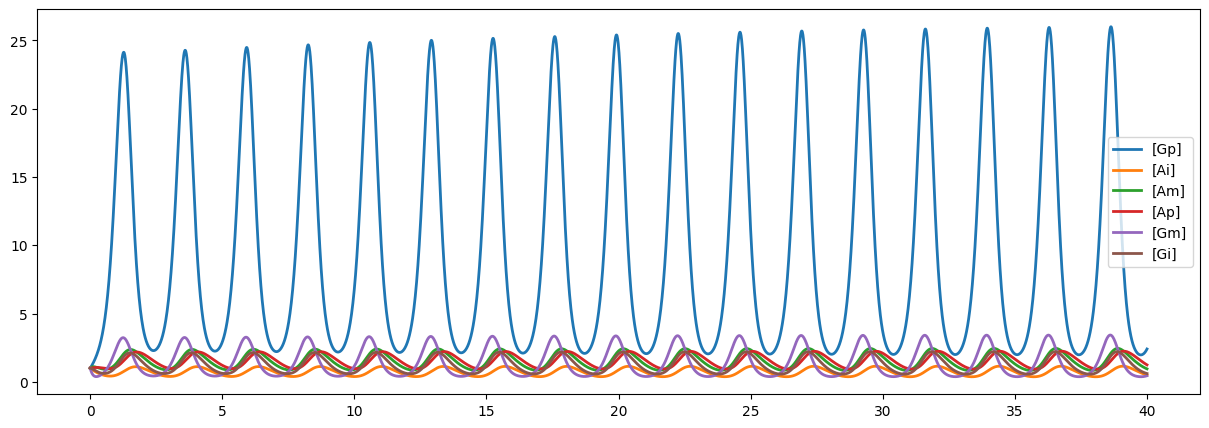

In [3]:
bsubtilus_CTLSB = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000001053.2?filename=Garde2020.xml", 
                        input_names=["Ai"], output_names=["Gp"])
bsubtilus_RR = bsubtilus_CTLSB.roadrunner
data = bsubtilus_RR.simulate(0, 40, 4000)
plot = bsubtilus_RR.plot(data,figsize=(15,5))


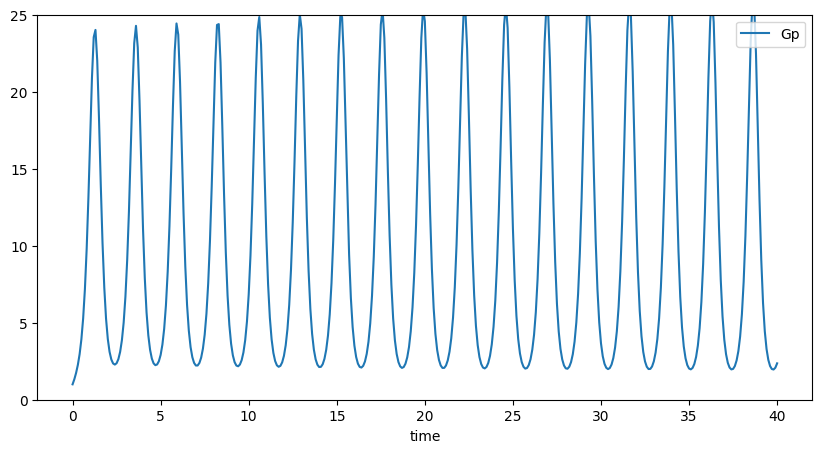

In [4]:
# Simulate the open loop system with no change in its input (at)
bsubtilus_sys = bsubtilus_CTLSB.makeNonlinearIOSystem("bsubtilus_sys")
ts = ctl.simulateSystem(bsubtilus_sys, end_time=40)
_ = ctl.plotOneTS(ts, figsize=(10,5), ylim=[0, 25])

**Control Objectives**

Control y(t) = Gp (mmol of Glutamate) using u(t) = Ai (mmol of Ammonia) in bacilus subtilus model. 

1. Eliminate the oscillations from ``Gp``
2. Coverge to 10.
3. Settling Time less than 5 seconds


# Question 2

In [5]:
def makePIController(kP, kI):
    """
    Makes a PI controller with control error as input
    
    Parameters
    ----------
    kP: float
    kI: float
    
    Returns
    -------
    NonlinearIOSystem
    """
    # Calculate derivative of state
    def updfcn(t, x, u, _):
        # Accumulate the control error
        # t: float (time)
        # x: array-float (state)
        # u: array-float (control error)
        # returns: array-float (derivative of state)
        return u[0]

    # Calculate output value
    def outfcn(t, x, u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        output = kI*x[0] + kP*u[0]
        return output

    controller = control.NonlinearIOSystem(
      updfcn,
      outfcn,
      states=1,
      inputs=['in'],
      outputs=['out'], name='controller_sys')
    return controller

# Tests
kP = 10
kI = 20
controller_sys = makePIController(kP=kP, kI=kI)
assert("NonlinearIOSystem" in str(type(controller_sys)))
print("OK")

OK


We form a closed loop system so that the output of the glycolytic system, ``sys.s5``, is
the input the the controller, ``controller.in``.
And, the output of the controller, ``controller.out``, is the input the glycolytic system.

OK


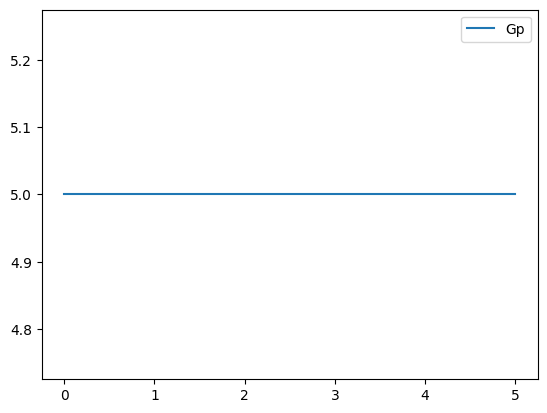

In [6]:
def makeAdder(input_names, output_name="out", system_name="adder_sys"):
    """
    Creates a NonlinearIOSystem that does addition
    of the inputs. Any name that begins wit a "-" is subtracted.
    
    Parameters
    ----------
    input_nmames: list-str
    output_name: str
    system_name: str
    
    Returns
    -------
    NonlinearIOSystem
    """
    adjustments = []
    adjusted_input_names = []
    def outfcn(_, __, u, ___):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        return adjustments.dot(u)
    #
    for name in input_names:
        if name[0] == "-":
            value = -1
            new_name = name[1:]
        else:
            value = 1
            new_name = name
        adjustments.append(value)
        adjusted_input_names.append(new_name)
    adjustments = np.array(adjustments)
    #
    return control.NonlinearIOSystem(
          None,
          outfcn,
          inputs=adjusted_input_names,
          outputs=output_name, name=system_name)

# Tests
adder_sys = makeAdder(["a", "-b", "c"])
assert("NonlinearIOSystem" in str(type(adder_sys)))
# Simulate to verify 
_, data, __ = plotSys(adder_sys, forced_input=[3, 2, 4], is_plot=True)
assert(np.var(data[0]) == 0)
assert(data[0][0] == 5)
print("OK")

**Comment**: It's better to not display the plot in the test code when you are providing the notebook as a research report.

In [7]:
def makeInterconnectWithDiffer(kP,kI, bsubtilus_sys=bsubtilus_sys):
    """
    Create an Interconnect object for the B Subtilus closed loop system.
    
    Parameters
    ----------
    bsubtilus_sys: NonlinearIOSystem
    kwargs: dict (arguments for makePIController)
    
    Returns
    -------
    Interconnect
    """
    controller_sys = makePIController(kP, kI)
    differ_sys = makeAdder(["setpoint", "-measurement"], system_name="differ_sys")
    closed_sys = control.interconnect(
      [bsubtilus_sys, controller_sys, differ_sys],       # systems
      connections=[
        ['differ_sys.measurement', "bsubtilus_sys.Gp"], 
        ['bsubtilus_sys.Ai', 'controller_sys.out'],
        ['controller_sys.in',  'differ_sys.out'],
      ],
      inplist=["differ_sys.setpoint"],
      outlist=["bsubtilus_sys.Gp"],
    )
    return closed_sys

# Tests
setpoint = 10
new_closed_sys = makeInterconnectWithDiffer(kP=20, kI=10)
assert("Interconnect" in str(type(new_closed_sys)))
_, data, ax = plotSys(new_closed_sys, forced_input=[setpoint], times=np.linspace(0, 20, 100), is_plot=False,
                      output_labels=["s5"])

print("OK!")

OK!


Text(0, 0.5, 'glutamate (mmol)')

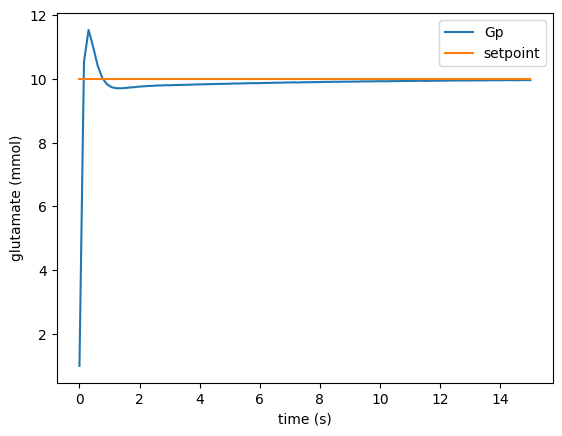

In [8]:
closed_sys = makeInterconnectWithDiffer(kP=15, kI=3)
times = np.linspace(0,15,100)
setpoint = 10
_ = plotSys(closed_sys, forced_input=[setpoint], times=times,
                      output_labels=["Gp"], ax=ax)
plt.legend(['Gp','setpoint'])
plt.xlabel('time (s)')
plt.ylabel('glutamate (mmol)')
#title="Closed Loop System", output_labels="Gp")
#ts = ctl.simulateSystem(closed_sys, end_time=end_time, output_names=["Gp"],forced_input = [10])
#ts["setpoint"] = Gp_SETPOINT

# Question 3

In [9]:
def makeFlakifier(p,kF):
    """
    Parameters
    ----------
    p: float 
    
    Returns
    -------
    NonlinearIOSystem
    """
    
    def updfcn(t, x, u, _):
        # Accumulate the control error
        # t: float (time)
        # x: array-float (state)
        # u: array-float (control error)
        # returns: array-float (derivative of state)
        num = np.random.rand()
        if num <= p:
            dx = 0
        else:
            dx = kF*u[0] - kF*x[0]
        return dx

    # Calculate output value
    def outfcn(t, x, u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        return x[0]

    flakifier = control.NonlinearIOSystem(
      updfcn,
      outfcn,
      states = 1,
      inputs=['in'],
      outputs=['out'], name='flakifier_sys')
    return flakifier

# Tests
p = 0.8
kF = 0.9
flakifier = makeFlakifier(p,kF)
assert("NonlinearIOSystem" in str(type(flakifier)))
print("OK")

OK


In [10]:
def makeInterconnectWithFlakifier(kP,kI,p,kF, bsubtilus_sys=bsubtilus_sys):
    """
    Create an Interconnect object for the B Subtilus closed loop system.
    
    Parameters
    ----------
    bsubtilus_sys: NonlinearIOSystem
    kwargs: dict (arguments for makePIController)
    
    Returns
    -------
    Interconnect
    """
    controller_sys = makePIController(kP, kI)
    differ_sys = makeAdder(["setpoint", "-measurement"], system_name="differ_sys")
    flakifier_sys = makeFlakifier(p,kF)
    closed_sys = control.interconnect(
      [bsubtilus_sys, controller_sys, differ_sys ,flakifier_sys],       # systems
      connections=[
        ['differ_sys.measurement', "bsubtilus_sys.Gp"], 
        ['flakifier_sys.in','controller_sys.out'],
        ['bsubtilus_sys.Ai', 'flakifier_sys.out'],
        ['controller_sys.in',  'differ_sys.out'],
      ],
      inplist=["differ_sys.setpoint"],
      outlist=["bsubtilus_sys.Gp"],
    )
    return closed_sys

# Tests
setpoint = 10
kP = 40
kI = 10
p = 0.8
kF = 0.8
flakifier_closed_sys = makeInterconnectWithFlakifier(kP,kI, p, kF)
assert("Interconnect" in str(type(flakifier_closed_sys)))
_, data, ax = plotSys(flakifier_closed_sys, forced_input=[setpoint], times=np.linspace(0, 20, 100), is_plot=False,
                      output_labels=["s5"])
#assert(data[0] == 8)
#assert(np.abs(setpoint - data[-1]) < 0.2)
print("OK!")

OK!


In [11]:
def testFlakifier(kP, kI, p):
    kF = 1
    times = np.linspace(0,50,100)
    flakifier_closed_sys = makeInterconnectWithFlakifier(kP,kI,p,kF)
    setpoint = 10
    _ = plotSys(flakifier_closed_sys, forced_input=[setpoint], output_labels=["Gp"], ax=ax, times = times)
    plt.legend(['Gp','setpoint'])
    plt.xlabel('time (s)')
    plt.ylabel('glutamate (mmol)')
    

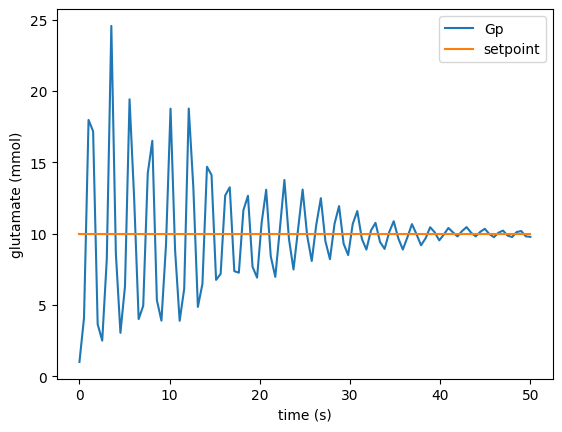

In [12]:
testFlakifier(6,5,0.8)

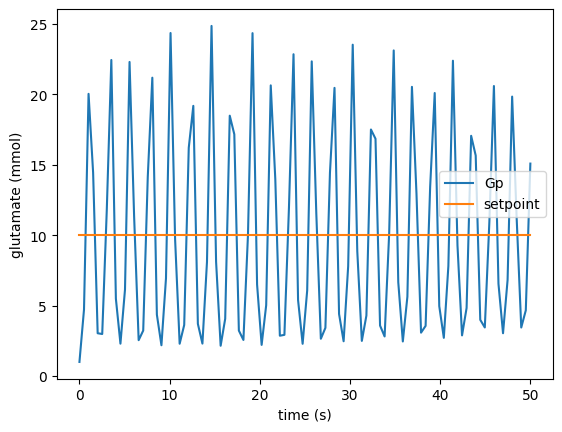

In [13]:
testFlakifier(0.5,0.1,0.2)

# Question 4
## Tuning CLS1
Tuning CLS1 was much easier than CLS2. I was quickly able to meet all of my control objectives that I had originally set including reaching a set point of 10, minimizing oscillations, and acheiving a quick settling point. The kP value was a larger magnitude than expected but increasing it steadily while exploring the parameter space made it clear that this system was better controlled with this high kP value. 

## Tuning CLS2
Tuning CLS2 was very difficult for me. The lowest value of p that I was able to achieve my set point was 0.8 and even then the system was very sensitive and often went unstable causing my test bed to error. Eventually, I was able to find parameters that at least reached the desired set point but the system still experiences a lot of oscillation and takes almost 8x longer to settle to that set point than CLS1. I was not able to tune the system with p = 0.2 to reach a set point and it took a lot of experimentation to even get the system somewhat stable as seen with the parameters directly above. This is more than likely due to a very small number of true measurements being passed to the controller as the flakifier returned 0 more often at this small p value. 

**comment** Did you explore the effect of $k_F$? This wasn't a requirement for the question, but I was curious.